### AG News Classification

***

### Import Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Read the dataset

In [5]:
df = pd.read_csv('agnews.csv')

### Save only a portion of the dataset

In [6]:
df = df[0:20000]

In [7]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### Shuffle the dataset

In [8]:
df = df.sample(frac = 1)

In [9]:
df.reset_index(drop = True, inplace = True)

In [10]:
for i in range(10):
    print(df['Description'][i],'-', df['Class Index'][i])
    print()

\\Indonesian authorities arrest the governor of Aceh province for alleged involvement in a corrupt helicopter purchase. - 1

Sproles ran for 221 yards and a touchdown to lead Kansas State to a lackluster 27-13 victory over Division I-AA Western Kentucky in the season opener for both teams. - 2

AP - Russian investigators labored Wednesday to determine whether terrorism caused the near-simultaneous crashes of two jetliners, killing all 89 people aboard and spreading anxieties about a possible bloody escalation of the Chechen conflict. - 1

TRIPOLI: Libya signed a deal yesterday to pay \$35 million (BD13m) in compensation to mainly German victims of a Berlin nightclub bombing 18 years ago. - 1

 NEW YORK (Reuters) - Krispy Kreme Doughnuts Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=KKD.N target=/stocks/quickinfo/fullquote"&gt;KKD.N&lt;/A&gt; on  Thursday posted sharply lower quarterly earnings, signaled that  the second half of the year would be weak and scaled

### Check Info

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  20000 non-null  int64 
 1   Title        20000 non-null  object
 2   Description  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


### View basic statistical information about the dataset

In [12]:
df.describe(include = 'all')

,Class Index,Title,Description
count,20000.000000,20000,20000
unique,NaN,19020,19781
top,NaN,SI.com,"ATHENS, Greece - Michael Phelps doesn't mind m..."
freq,NaN,13,4
mean,2.484500,NaN,NaN
std,1.133633,NaN,NaN
min,1.000000,NaN,NaN
25%,1.000000,NaN,NaN
50%,2.000000,NaN,NaN
75%,4.000000,NaN,NaN


### Check for missing values

In [13]:
df.isna().sum()

Class Index    0
Title          0
Description    0
dtype: int64

### Check for duplicates

In [14]:
df.duplicated().sum()

0

### Plot a countplot of the Class Index

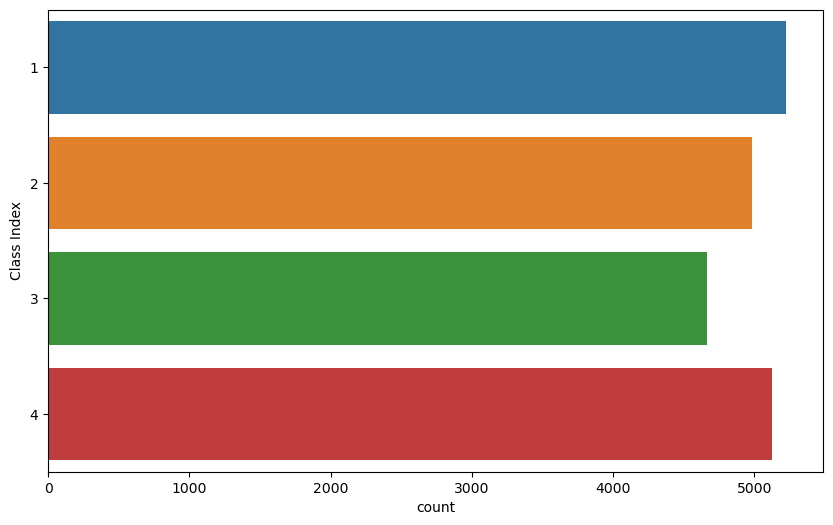

In [15]:
plt.figure(figsize = (10,6))
sns.countplot(y = df['Class Index'])
plt.show()

### Create a funciton to preprocess the text

In [16]:
def preprocess(sentence):
    #removes all the special characters and split the sentence at spaces
    text = re.sub(r"[^a-zA-Z0-9]"," ",sentence).split()
    
    # converts words to lowercase and removes any stopwords
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    
    # Lemmatize the words
    lemma = WordNetLemmatizer()
    word = [lemma.lemmatize(word,'v') for word in words ]
    
    # convert the list of words back into a sentence
    word = ' '.join(word)
    return word

### Apply the preprocess function to the description

In [18]:
df['Description'] = df['Description'].apply(preprocess)

In [19]:
for i in range(10):
    print(df['Description'][i],'-', df['Class Index'][i])
    print()

indonesian authorities arrest governor aceh province allege involvement corrupt helicopter purchase - 1

sproles run 221 yards touchdown lead kansas state lackluster 27 13 victory division aa western kentucky season opener team - 2

ap russian investigators labor wednesday determine whether terrorism cause near simultaneous crash two jetliners kill 89 people aboard spread anxieties possible bloody escalation chechen conflict - 1

tripoli libya sign deal yesterday pay 35 million bd13m compensation mainly german victims berlin nightclub bomb 18 years ago - 1

new york reuters krispy kreme doughnuts inc lt href http www investor reuters com fullquote aspx ticker kkd n target stock quickinfo fullquote gt kkd n lt gt thursday post sharply lower quarterly earn signal second half year would weak scale back store open batter low carbohydrate diet craze - 3

athens adrian annus hungary athens olympic men 39 hammer throw champion embroil dope scandal appear hear international olympic committee 3

### Split Input & Target Variables

In [20]:
X = df['Description']
y = df['Class Index']

### One Hot encode our Target Variable

In [21]:
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

In [22]:
labels = encoder.classes_
labels

array([1, 2, 3, 4], dtype=int64)

### Split the dataset into Training & Testing Set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

### Create a keras Tokenizer object

In the Keras library, the Tokenizer is a class that can be used to preprocess text data. It allows you to convert a collection of text documents into a numerical representation that can be used as input to a machine learning model.

In [24]:
tokenizer = Tokenizer(num_words=5000)

### fit on text for our X

In [25]:
tokenizer.fit_on_texts(X)

In [26]:
vocab_size = len(tokenizer.word_index) + 1

### Create a function to convert text to numerical representation and add padding

In [27]:
def text_encoding(txt):
    # texts_to_sequences Transforms each text in texts to a sequence of integers.
    encoded_docs = tokenizer.texts_to_sequences(txt)
    
    # pad_sequences is used to ensure that all sequences in a list have the same length.
    padded_sequence = pad_sequences(encoded_docs, maxlen=128)    
       
    return padded_sequence

### Apply the function to our X_train & X_test

In [28]:
X_train = text_encoding(X_train)
X_test = text_encoding(X_test)

### Create keras Sequential model with GRU Layers

In [29]:
model = Sequential()
### Embedding layer
model.add(layers.Embedding(vocab_size, 128))

### GRU layer
### return_sequences: Whether to return the last output in the output sequence, or the full sequence.
model.add(layers.GRU(128,  return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(128))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2966912   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

### Compile the model

In [31]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Train the model with our Training Set

In [32]:
model.fit(X_train, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
400/400 [==============================] - 94s 225ms/step - loss: 0.6198 - accuracy: 0.7581 - val_loss: 0.4041 - val_accuracy: 0.8672
Epoch 2/10
400/400 [==============================] - 88s 221ms/step - loss: 0.3013 - accuracy: 0.9035 - val_loss: 0.4324 - val_accuracy: 0.8612
Epoch 3/10
400/400 [==============================] - 415s 1s/step - loss: 0.2209 - accuracy: 0.9295 - val_loss: 0.4905 - val_accuracy: 0.8556
Epoch 4/10
400/400 [==============================] - 87s 219ms/step - loss: 0.1644 - accuracy: 0.9441 - val_loss: 0.5553 - val_accuracy: 0.8494
Epoch 5/10
400/400 [==============================] - 87s 219ms/step - loss: 0.1287 - accuracy: 0.9591 - val_loss: 0.5833 - val_accuracy: 0.8481
Epoch 6/10
400/400 [==============================] - 88s 220ms/step - loss: 0.0950 - accuracy: 0.9674 - val_loss: 0.7388 - val_accuracy: 0.8372
Epoch 7/10
400/400 [==============================] - 87s 217ms/step - loss: 0.0812 - accuracy: 0.9723 - val_loss: 0.7876 - val_accu

### Make predictions with Test set

In [61]:
y_pred = model.predict(X_test)

125/125 [==============================] - 12s 55ms/step


In [62]:
y_pred = [np.argmax(i) for i in y_pred]

In [63]:
y_test = [np.argmax(i) for i in y_test]

### Check accuracy score

In [65]:
accuracy_score(y_test, y_pred)

0.8405

### Confusion matrix

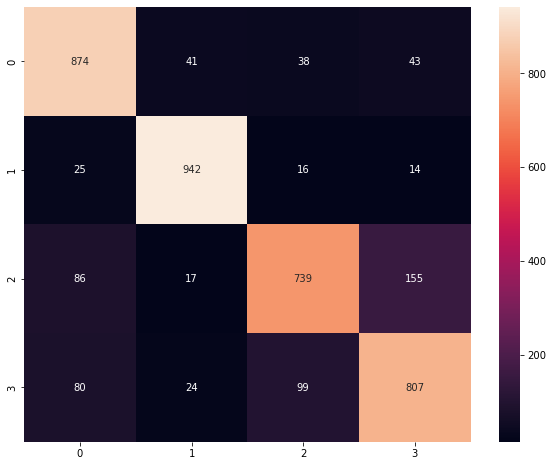

In [66]:
plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd')
plt.show()

### Classification Report

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       996
           1       0.92      0.94      0.93       997
           2       0.83      0.74      0.78       997
           3       0.79      0.80      0.80      1010

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



***